This is a notebook that analyses the data from XCMS run in positive mode.

In [1]:
import pandas, numpy, seaborn, qnorm

In [2]:
import scipy, scipy.signal, scipy.stats
import statsmodels, statsmodels.stats, statsmodels.stats.multitest
import sklearn, sklearn.preprocessing, sklearn.decomposition

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':20
                           })

# user-defined variables

In [4]:
input_data_file = '/home/adrian/projects/vigur/data/lipidomics/072/xcms/pos/PMVECs_EC72_Lipids_POS_29032022_withIS.csv'
metadata_file = '/home/adrian/projects/vigur/data/lipidomics/072/xcms/pos/EC-072 SAMPLE LIST_BATCHES_FORLCMS_INTRA_Lipidomics_FINAL_23032022.xlsx'

# read information

## read data

In [5]:
df = pandas.read_csv(input_data_file)
df.shape

/tmp/ipykernel_22788/1072133223.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(input_data_file)


(22507, 223)

## read metadata

In [6]:
metadata = pandas.read_excel(metadata_file, sheet_name='Master Sample List POS', index_col='File')
metadata.head()

,LCMS_SAMPLE,MS file,LC file,Sample ID,Experiment,Timepoint,Treatment,Rep,M/R/C,Total cells per well,Cell Count,MS BATCH,MS BATCH.1,Polarity
File,,,,,,,,,,,,,,
EC72_Lipidomics_000094,Solvent,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2_1,POS
EC72_Lipidomics_000095,Pool,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2_1,POS
EC72_Lipidomics_000096,Solvent,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2_1,POS
EC72_Lipidomics_000097,POS_072-153_5 µM epi:nor_24,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,072-153,2.0,24.0,5 µM epi:nor,1.0,C,3.33*10^5,333000.0,2.0,B2_1,POS
EC72_Lipidomics_000098,POS_072-156_TNFa_24,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,072-156,2.0,24.0,TNFa,1.0,C,3.40*10^5,340000.0,2.0,B2_1,POS


# manipulate information

In [7]:
# merge mz and RT as unique identifier
df.loc[:, 'unique_ID'] = df.loc[:, 'rt'].astype(str) + '_' + df.loc[:, 'mz'].astype(str)
df.set_index('unique_ID', inplace=True)
df.sort_index(inplace=True)

print(df.shape)
df.head()

(22507, 223)


,Unnamed: 0,mz,mzmin,mzmax,rt,rtmin,rtmax,rt(min),Internal Standard,LIPIDOMIX,...,EC72_Lipidomics_000210,EC72_Lipidomics_000211,EC72_Lipidomics_000212,EC72_Lipidomics_000213,EC72_Lipidomics_000214,EC72_Lipidomics_000215,EC72_Lipidomics_000216,isotopes,adduct,pcgroup
unique_ID,,,,,,,,,,,,,,,,,,,,,
100.182_313.2191795,4078,313.219179,313.213665,313.221599,100.182,97.190,105.976,1.669700,0,0,...,1499.464271,1596.832728,1721.638866,2364.582662,324.896726,2943.661044,276.581228,NaN,NaN,219
100.186_205.1947963,1931,205.194796,205.192206,205.197094,100.186,97.185,112.790,1.669767,0,0,...,324.320189,490.950726,276.207656,1177.067695,116.216646,1804.983562,112.533165,NaN,[M+K]+ 166.232 [M+Na]+ 182.206 [M+H]+ 204.188 ...,219
100.282_293.2459014,3627,293.245901,293.241772,293.248284,100.282,93.624,105.651,1.671367,0,0,...,829.775613,1040.545417,1051.947575,3076.865782,274.891832,4034.417035,256.762100,NaN,NaN,4477
100.415_663.4968406,13451,663.496841,663.487577,663.499662,100.415,97.189,105.976,1.673583,0,0,...,947.513880,1046.274579,1038.485702,1232.515987,49.803111,1146.301707,93.274746,[1564][M+3]+,NaN,219
100.456_643.4610967,12858,643.461097,643.447964,643.466081,100.456,96.217,105.651,1.674267,0,0,...,590.575463,613.970705,919.034624,1089.917966,126.446368,1020.589890,106.716415,NaN,[M+H]+ 642.458,219


In [8]:
# We need a dataframe for samples, another for pools and another one for samples and pools.
pools_IDs = list(metadata[metadata['LCMS_SAMPLE'].str.contains("Pool")].index)
samples_IDs = list(metadata[metadata['LCMS_SAMPLE'].str.contains("072")].index)
pools_and_samples_IDs = pools_IDs + samples_IDs
pools_IDs.sort(); samples_IDs.sort(); pools_and_samples_IDs.sort()
print(len(pools_IDs), len(samples_IDs), len(pools_and_samples_IDs))

pools_intensities = df.loc[:, pools_IDs]
samples_intensities = df.loc[:, samples_IDs]
pools_and_samples_intensities = df.loc[:, pools_and_samples_IDs]

log10_pools_intensities = numpy.log10(pools_intensities + 1)
log10_samples_intensities = numpy.log10(samples_intensities + 1)
log10_pools_and_samples_intensities = numpy.log10(pools_and_samples_intensities + 1)

print(log10_pools_intensities.shape)
print(log10_samples_intensities.shape)
print(log10_pools_and_samples_intensities.shape)

24 132 156
(22507, 24)
(22507, 132)
(22507, 156)


We have 22,501 features.

In [9]:
# get the internal standards
issmetabolites1 = df[df['Internal Standard'] == 1].index.to_list()
issmetabolites2 = df[df['LIPIDOMIX'] == 1].index.to_list()
IS_IDs = issmetabolites1 + issmetabolites2

print(issmetabolites1)
print(issmetabolites2)

['241.185_538.3888529', '384.765_717.5927542', '385.637_720.5614759', '427.528_762.603288', '473.383_818.666092', '587.8635_866.8187716']
['390.398_753.6146978', '563.0_829.8007716']


# visualize information

## histogram across retention time

15.916716666666668
0.09758333333333334


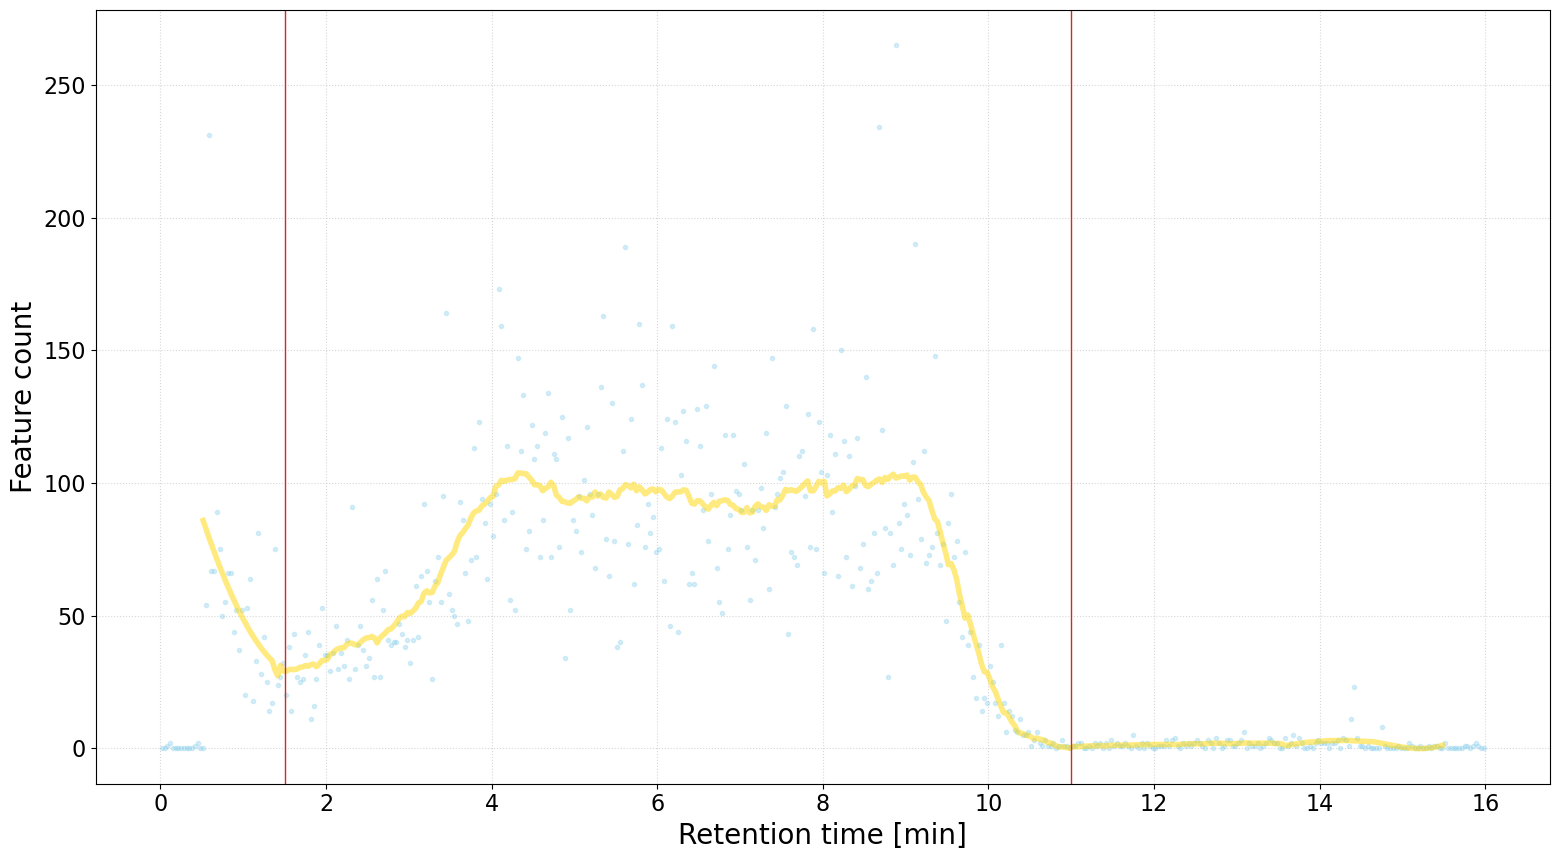

In [10]:
values = df['rt']/60

print(numpy.max(values))
print(numpy.min(values))

found_min = 0 
found_max = 16
number_of_bins = found_max*30

hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(found_min, found_max))
half_bin = (bin_edges[1] - bin_edges[0])/2
x = bin_edges + half_bin
x = x[:-1]

matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color='skyblue')

margin = 15
plotting_x = x[margin:number_of_bins-margin]
plotting_hist = hist[margin:number_of_bins-margin]

yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color='gold')
      
matplotlib.pyplot.xlabel('Retention time [min]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.axvline(x=1.5, lw=1, color='tab:red')
matplotlib.pyplot.axvline(x=11, lw=1, color='tab:red')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [11]:
print(df.shape)
df = df[df['rt'] >= 1.5*60]
print(df.shape)
df = df[df['rt'] <= 11*60]
print(df.shape)

(22507, 223)
(20943, 223)
(20715, 223)


## visualize internal standards

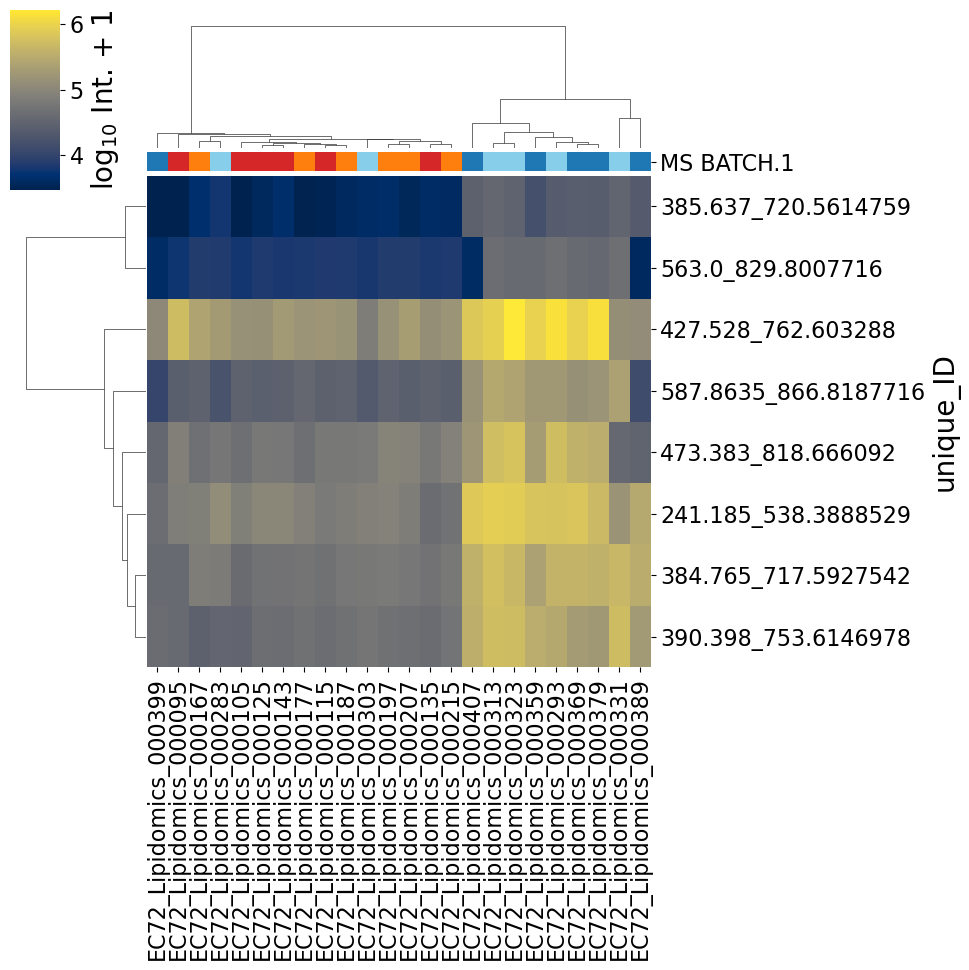

In [12]:
palette = dict(zip(['B1_1', 'B1_2', 'B2_1', 'B2_2'], ['skyblue','tab:blue','tab:red', 'tab:orange']))
my_col_colors = metadata.loc[log10_pools_intensities.columns, 'MS BATCH.1'].map(palette)

pdf = log10_pools_intensities.loc[IS_IDs, :]

seaborn.clustermap(pdf, row_cluster=True, col_cluster=True, cmap='cividis',
                   method='ward', metric='euclidean', 
                   col_colors=my_col_colors,
                   cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                   )
matplotlib.pyplot.show()

## visualize samples

In [13]:
log10_pools_and_samples_intensities.shape

(22507, 156)

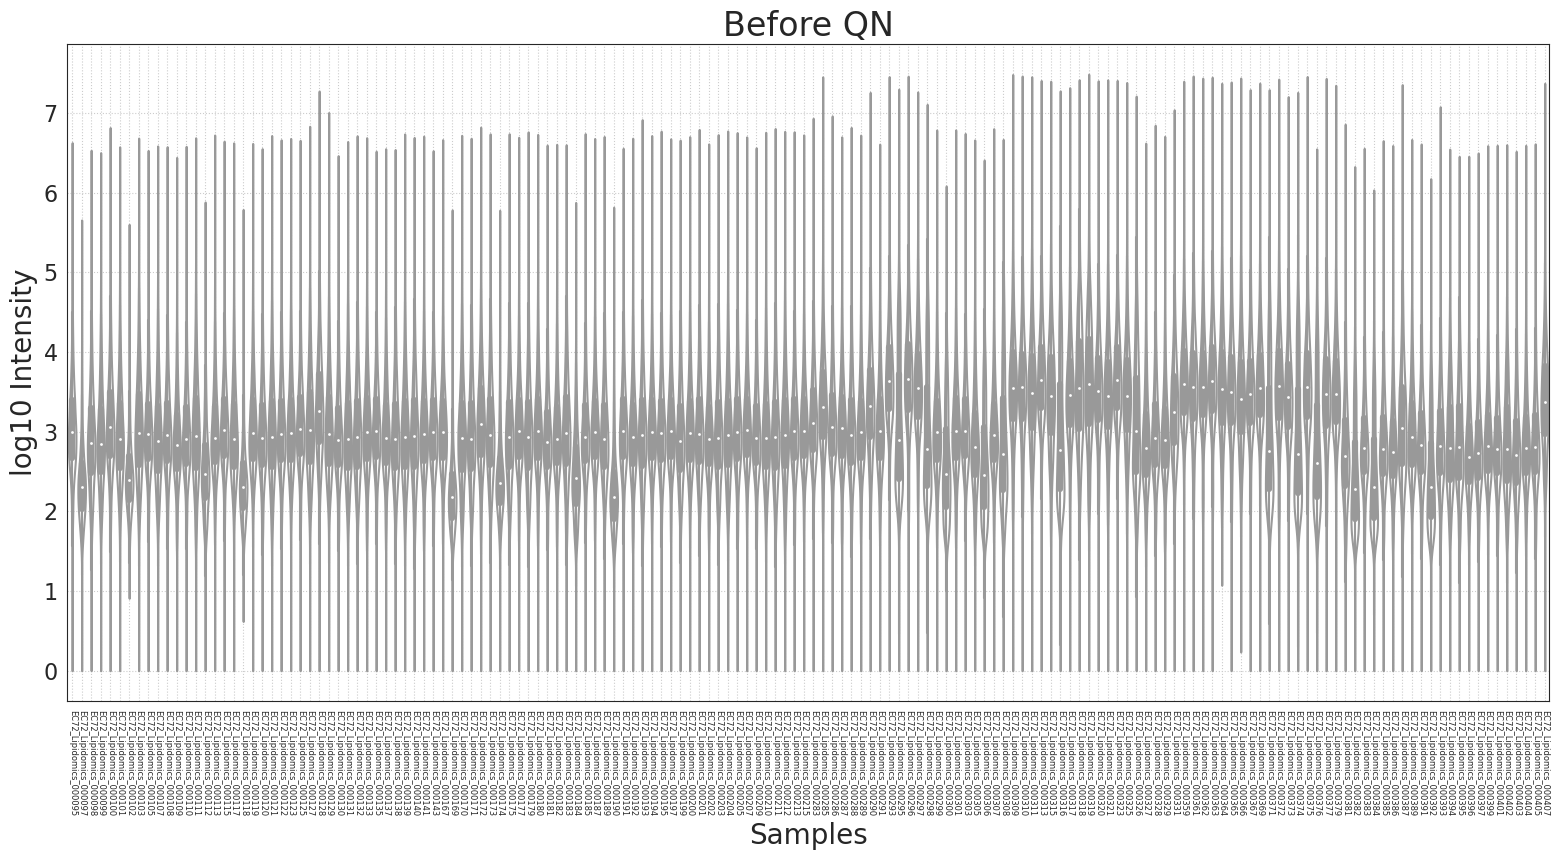

In [14]:
seaborn.set_style("white")
g = seaborn.violinplot(data=log10_pools_and_samples_intensities, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='Before QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# quantile normalization

In [15]:
###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_pools_and_samples_intensities.values, axis=0), 
                             index=log10_pools_and_samples_intensities.index, 
                             columns=log10_pools_and_samples_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_pools_and_samples_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

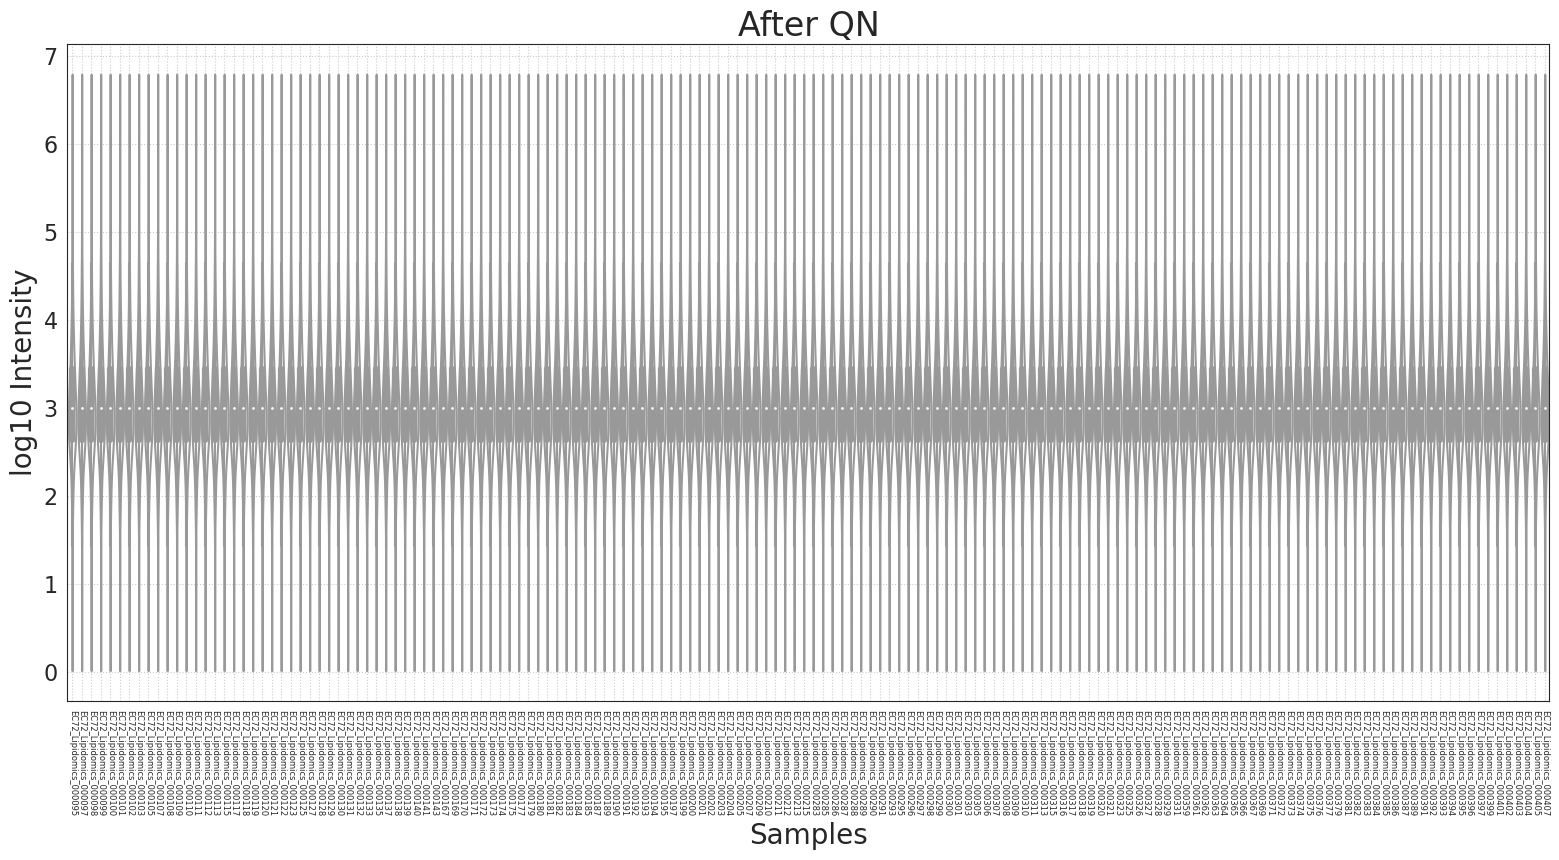

In [16]:
g = seaborn.violinplot(data=df_qn, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [17]:
mqndf = qnorm.quantile_normalize(log10_pools_and_samples_intensities, axis=1)

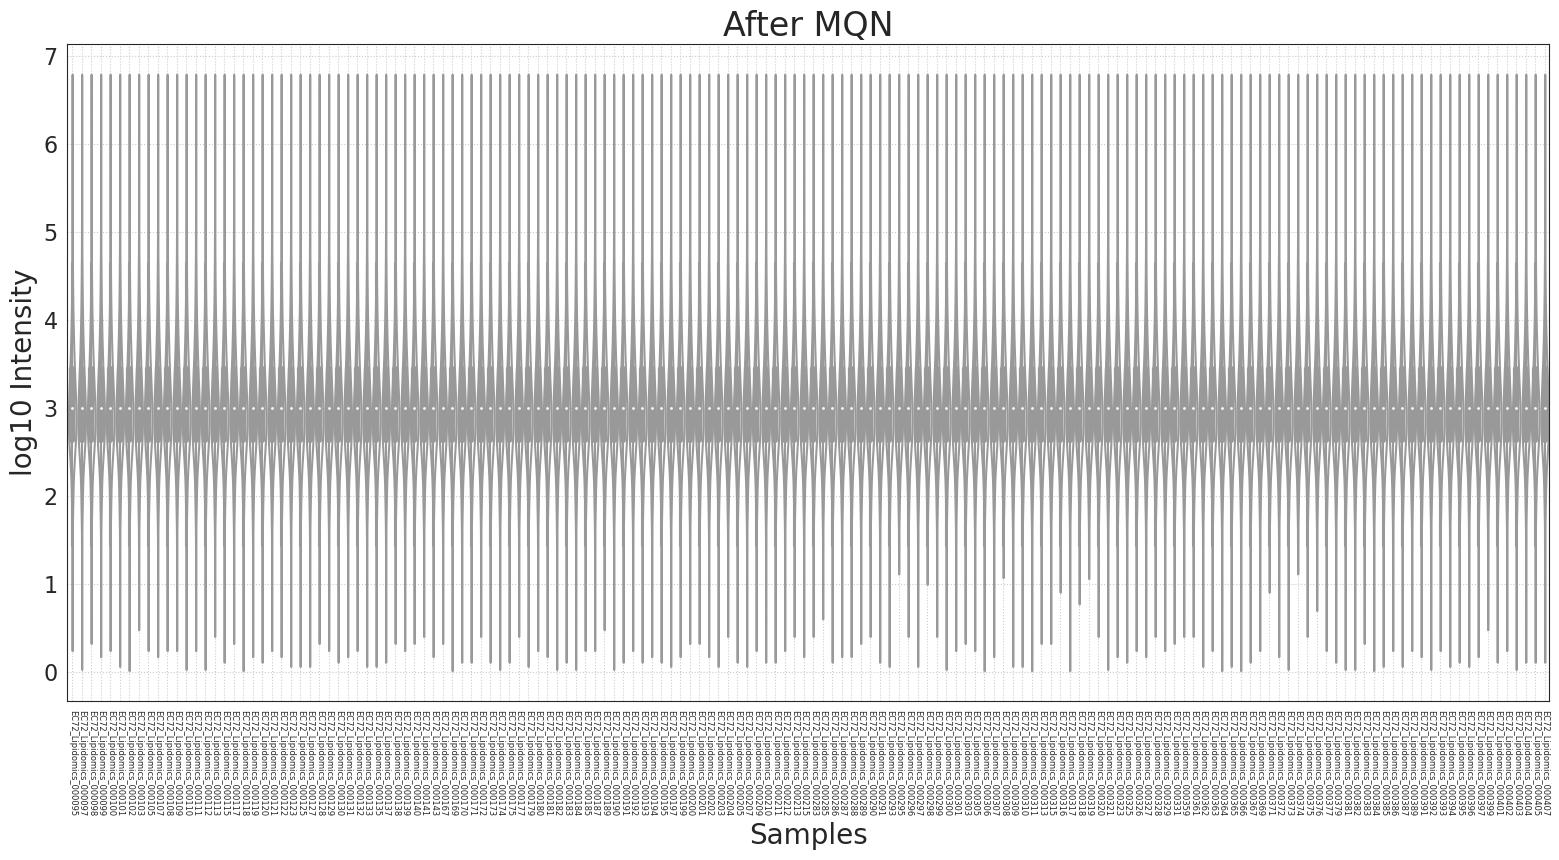

In [18]:
g = seaborn.violinplot(data=mqndf, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After MQN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# visualize IS in pools after normalization

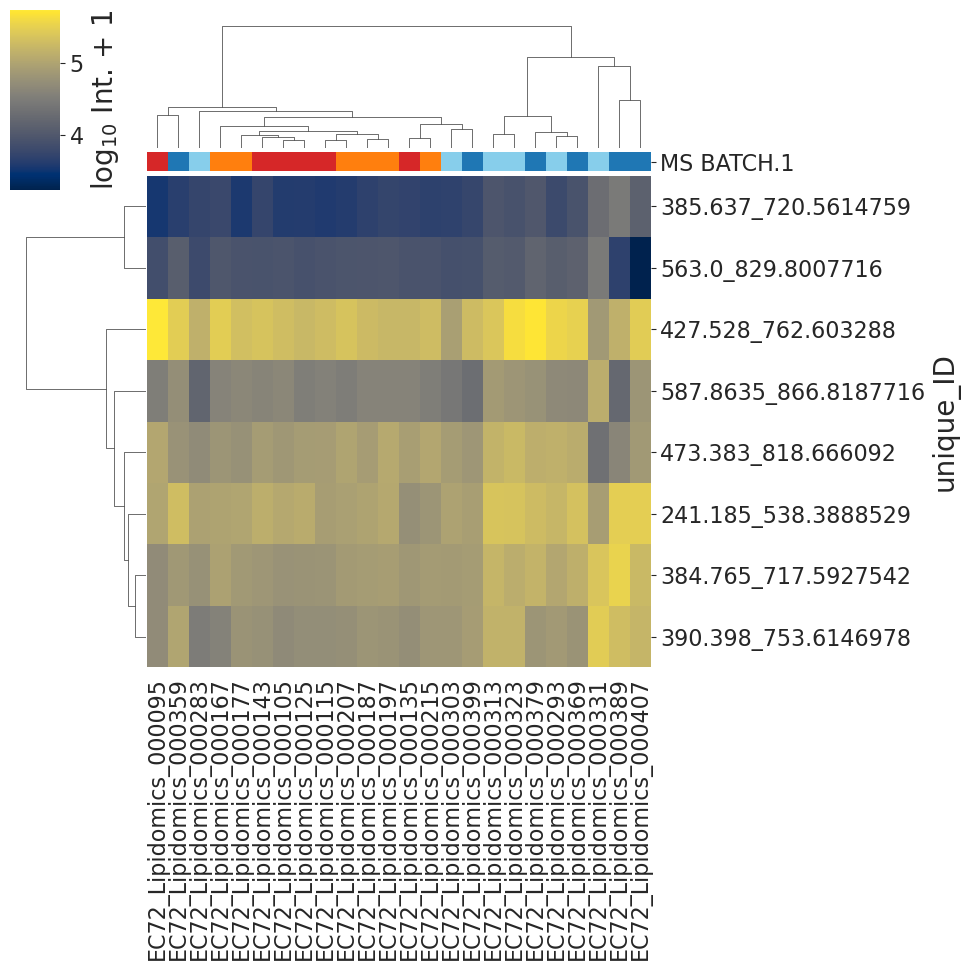

In [19]:
pdf = df_qn.loc[IS_IDs, pools_IDs]

palette = dict(zip(['B1_1', 'B1_2', 'B2_1', 'B2_2'], ['skyblue','tab:blue','tab:red', 'tab:orange']))
my_col_colors = metadata.loc[pdf.columns, 'MS BATCH.1'].map(palette)

seaborn.clustermap(pdf, row_cluster=True, col_cluster=True, cmap='cividis',
                   method='ward', metric='euclidean', 
                   col_colors=my_col_colors,
                   cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                   )
matplotlib.pyplot.show()

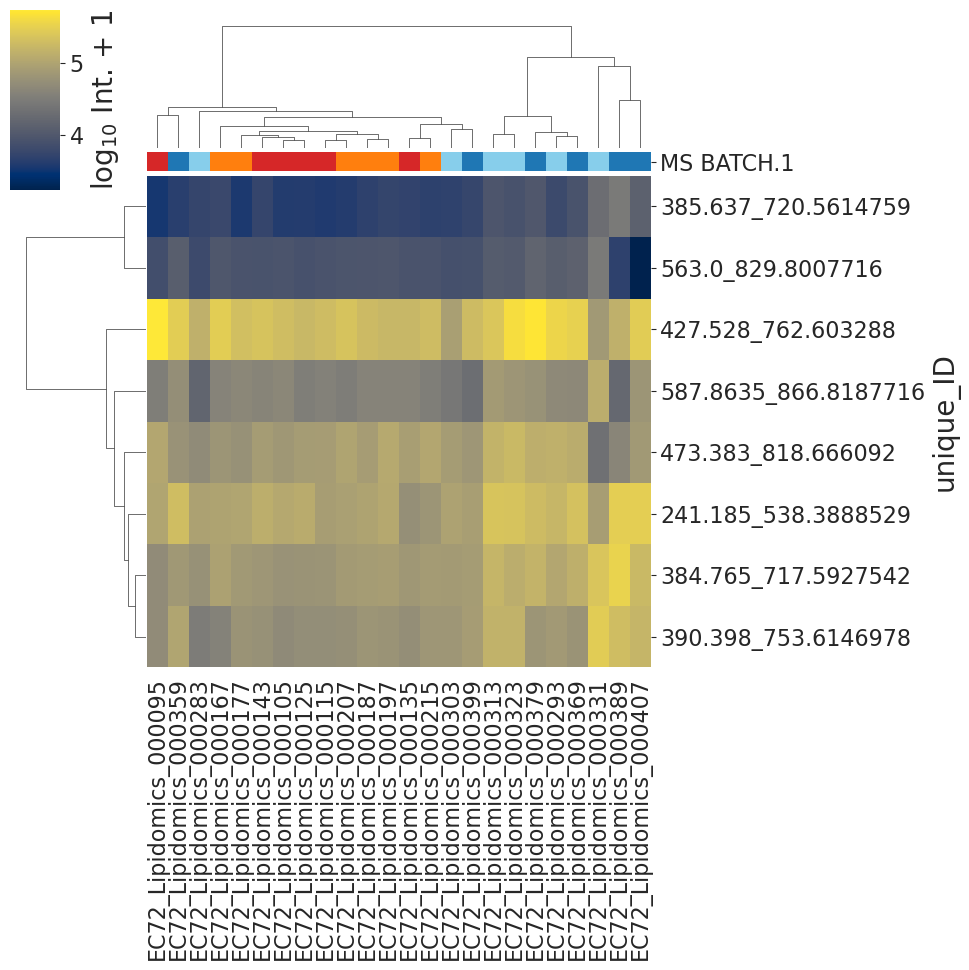

In [20]:
pdf = mqndf.loc[IS_IDs, pools_IDs]

palette = dict(zip(['B1_1', 'B1_2', 'B2_1', 'B2_2'], ['skyblue','tab:blue','tab:red', 'tab:orange']))
my_col_colors = metadata.loc[pdf.columns, 'MS BATCH.1'].map(palette)

seaborn.clustermap(pdf, row_cluster=True, col_cluster=True, cmap='cividis',
                   method='ward', metric='euclidean', 
                   col_colors=my_col_colors,
                   cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                   )
matplotlib.pyplot.show()

# check CV before and after quantile normalization

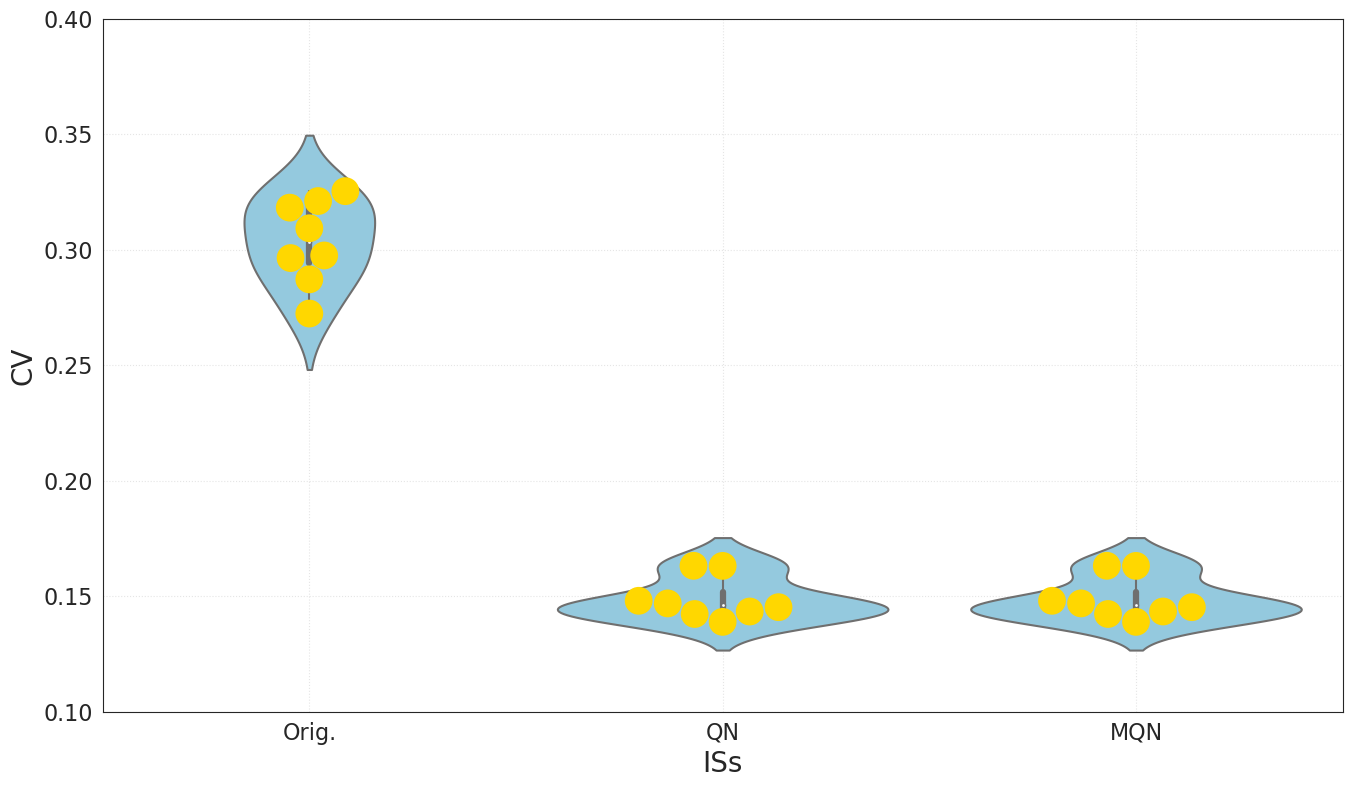

In [21]:
a = log10_pools_and_samples_intensities.loc[IS_IDs, pools_IDs]
b = df_qn.loc[IS_IDs, pools_IDs]
c = mqndf.loc[IS_IDs, pools_IDs]

sb = a.std(axis=1)
sln = sb*numpy.log(2)
term = numpy.exp(sln**2)
cva = numpy.sqrt(term - 1)

sb = b.std(axis=1)
sln = sb*numpy.log(2)
term = numpy.exp(sln**2)
cvb = numpy.sqrt(term - 1)

sb = c.std(axis=1)
sln = sb*numpy.log(2)
term = numpy.exp(sln**2)
cvc = numpy.sqrt(term - 1)

seaborn.violinplot([cva, cvb, cvc], color='skyblue')
canvas = seaborn.swarmplot(data=[cva.values, cvb.values, cvc.values], palette = ['gold', 'gold', 'gold'], size=20)
canvas.set_xticklabels(['Orig.','QN','MQN'])

matplotlib.pyplot.ylim(0.1, 0.4)

matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.xlabel('ISs')
matplotlib.pyplot.ylabel('CV')
matplotlib.pyplot.show()

In [22]:
# the two metabolites from LIPIDOMIX are not the top variant
print(issmetabolites2)
cvc

['390.398_753.6146978', '563.0_829.8007716']


unique_ID
241.185_538.3888529     0.143383
384.765_717.5927542     0.145255
385.637_720.5614759     0.163130
427.528_762.603288      0.148024
473.383_818.666092      0.138893
587.8635_866.8187716    0.142305
390.398_753.6146978     0.163177
563.0_829.8007716       0.146890
dtype: float64

# remove features with more than 33% of CV in pools 

In [23]:
df = mqndf.loc[:, pools_IDs]

sb = df.std(axis=1)
sln = sb*numpy.log(2)
term = numpy.exp(sln**2)
cv_mqndf = numpy.sqrt(term - 1)

In [24]:
print(cv_mqndf.index.shape)
reliable_features = cv_mqndf[cv_mqndf < 1/3].index
print(reliable_features.shape)

(22507,)
(21150,)


1.5785711543468484
0.041608192908326215
640


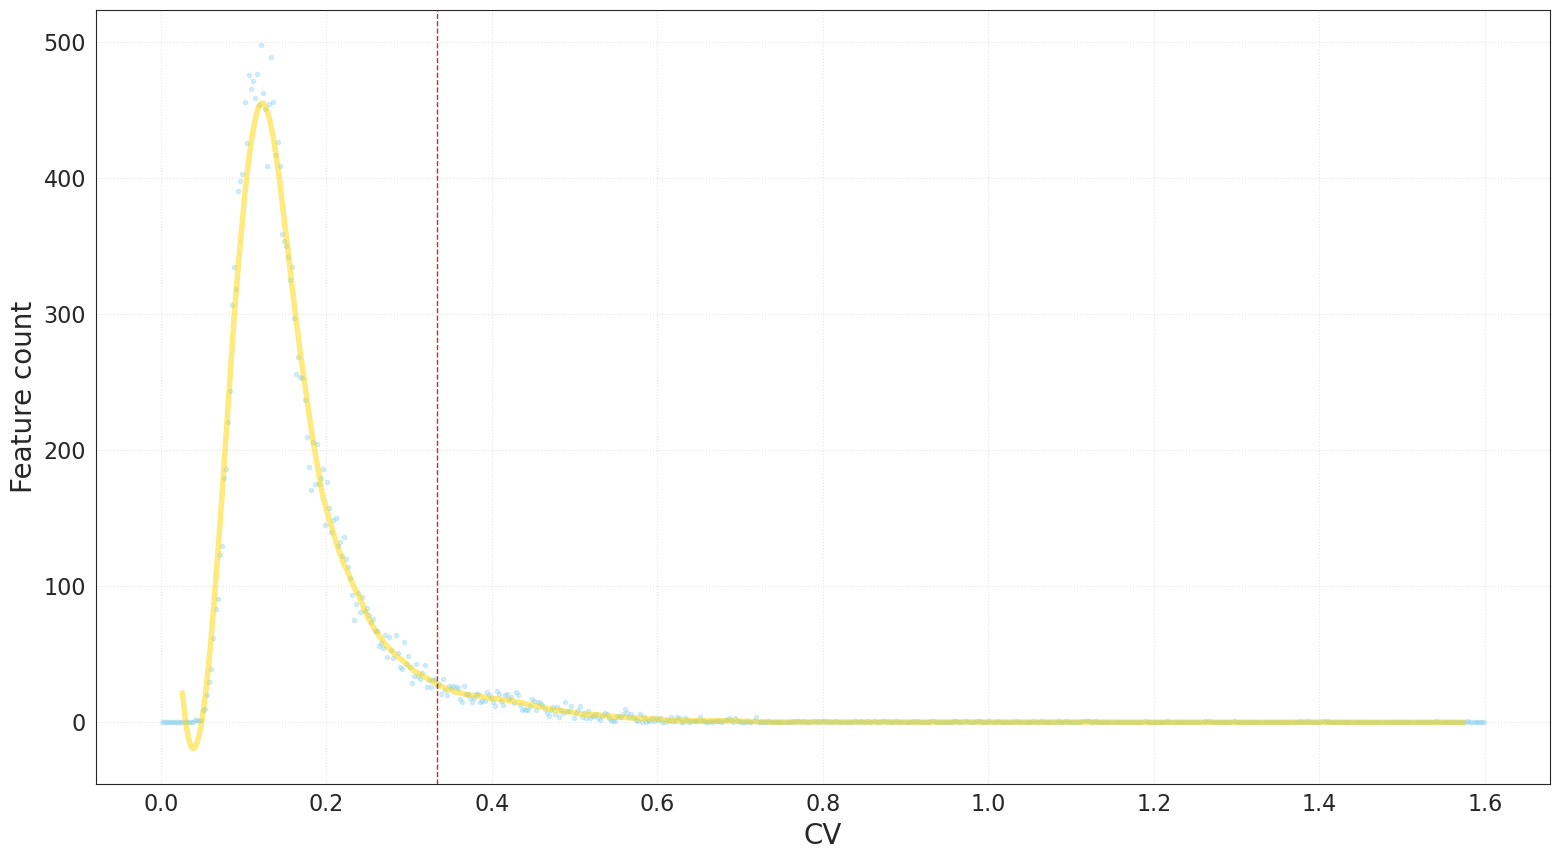

In [25]:
values = cv_mqndf

print(numpy.max(values))
print(numpy.min(values))

found_min = 0 
found_max = 1.6
number_of_bins = int(found_max*400)
print(number_of_bins)

hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(found_min, found_max))
half_bin = (bin_edges[1] - bin_edges[0])/2
x = bin_edges + half_bin
x = x[:-1]

matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color='skyblue')

margin = 10
plotting_x = x[margin:number_of_bins-margin]
plotting_hist = hist[margin:number_of_bins-margin]

yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color='gold')
      
matplotlib.pyplot.xlabel('CV')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.axvline(x=1/3, lw=1, ls='--', color='tab:red')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [26]:
print(mqndf.shape)
mqndf = mqndf.loc[reliable_features, :]
print(mqndf.shape)

(22507, 156)
(21150, 156)


# make a PCA of what we have

## batch one

variance explained [0.37067179 0.08390707]
(78, 2)
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/tmp/ipykernel_22788/2676177894.py:56: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('none').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, marker=plotting_marker, edgecolors='none')


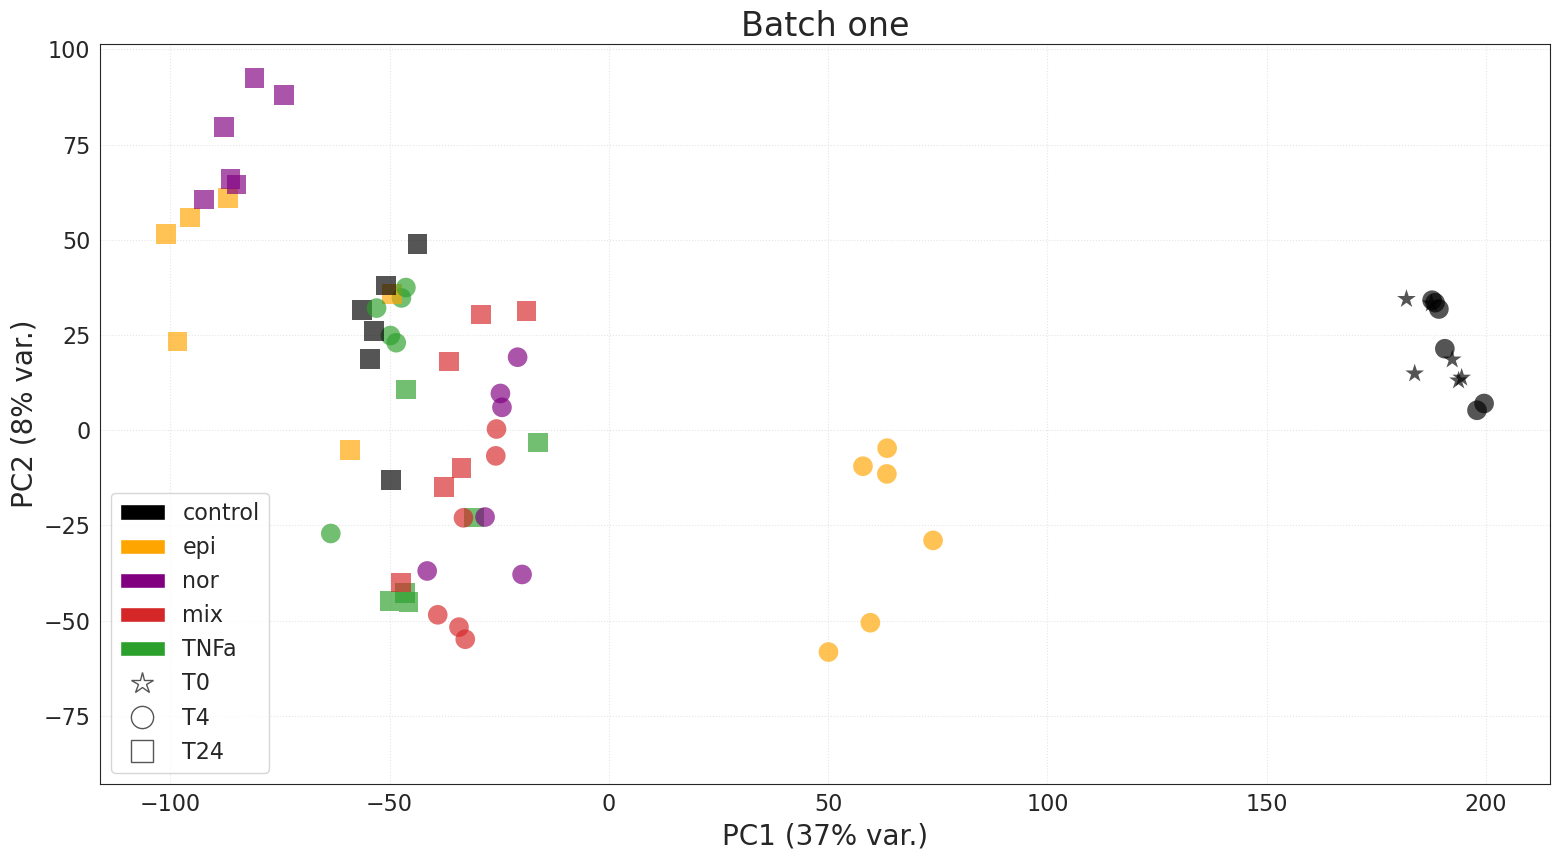

In [57]:
sampleIDs = mqndf.columns
subset_metadata = metadata.loc[sampleIDs, :]
batch_one_samples = subset_metadata[(subset_metadata['MS BATCH.1'] == 'B1_1') | (subset_metadata['MS BATCH.1'] == 'B1_2')].index
df = mqndf.loc[:, batch_one_samples]
df = df.transpose()

x = sklearn.preprocessing.StandardScaler().fit_transform(df)
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print('variance explained', pca.explained_variance_ratio_)

print(principal_df.shape)
principal_df.head()

for i in range(len(df.index)):
    
    label = df.index[i]
    
    # color for treatment
    treatment = metadata.loc[label, 'Treatment']
    if treatment == '0 µM' or treatment == '0µM' or type(treatment) == float:
        plotting_color = 'black'
    elif treatment == '5 µM epi':
        plotting_color = 'orange'
    elif treatment == '5 µM nor':
        plotting_color = 'purple'
    elif treatment == '5 µM epi:nor':
        plotting_color = 'tab:red'
    elif treatment == 'TNFa':
        plotting_color = 'tab:green'
    else:
        plotting_color = 'blue'
        print(treatment, type(treatment))
    
    # marker for pools or real sample
    long_sample_name = metadata.loc[label, 'LCMS_SAMPLE']
    timepoint = metadata.loc[label, 'Timepoint']
    if timepoint == 0:
        plotting_marker = '*'
    elif timepoint == 4:
        plotting_marker = 'o'
    elif timepoint == 24:
        plotting_marker = 's'
    else:
        print(timepoint)
    if '072' not in long_sample_name:
        plotting_marker = 'none'

    # position
    posx = principal_df.iloc[i]['PC1']
    posy = principal_df.iloc[i]['PC2']

    # plot the dots
    matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, marker=plotting_marker, edgecolors='none')
    
# legend
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='orange', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='purple', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white'),
    
    matplotlib.lines.Line2D([0], [0], marker='*', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='s', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0)
    ]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'mix', 'TNFa', 'T0', 'T4', 'T24'], fontsize=16)


# close figure
matplotlib.pyplot.title('Batch one')
matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1 ({}% var.)'.format(int(pca.explained_variance_ratio_[0]*100)))
matplotlib.pyplot.ylabel('PC2 ({}% var.)'.format(int(pca.explained_variance_ratio_[1]*100)))

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
## batch two

variance explained [0.33617423 0.17254409]
(78, 2)
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/tmp/ipykernel_22788/3051768689.py:56: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('none').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, marker=plotting_marker, edgecolors='none')


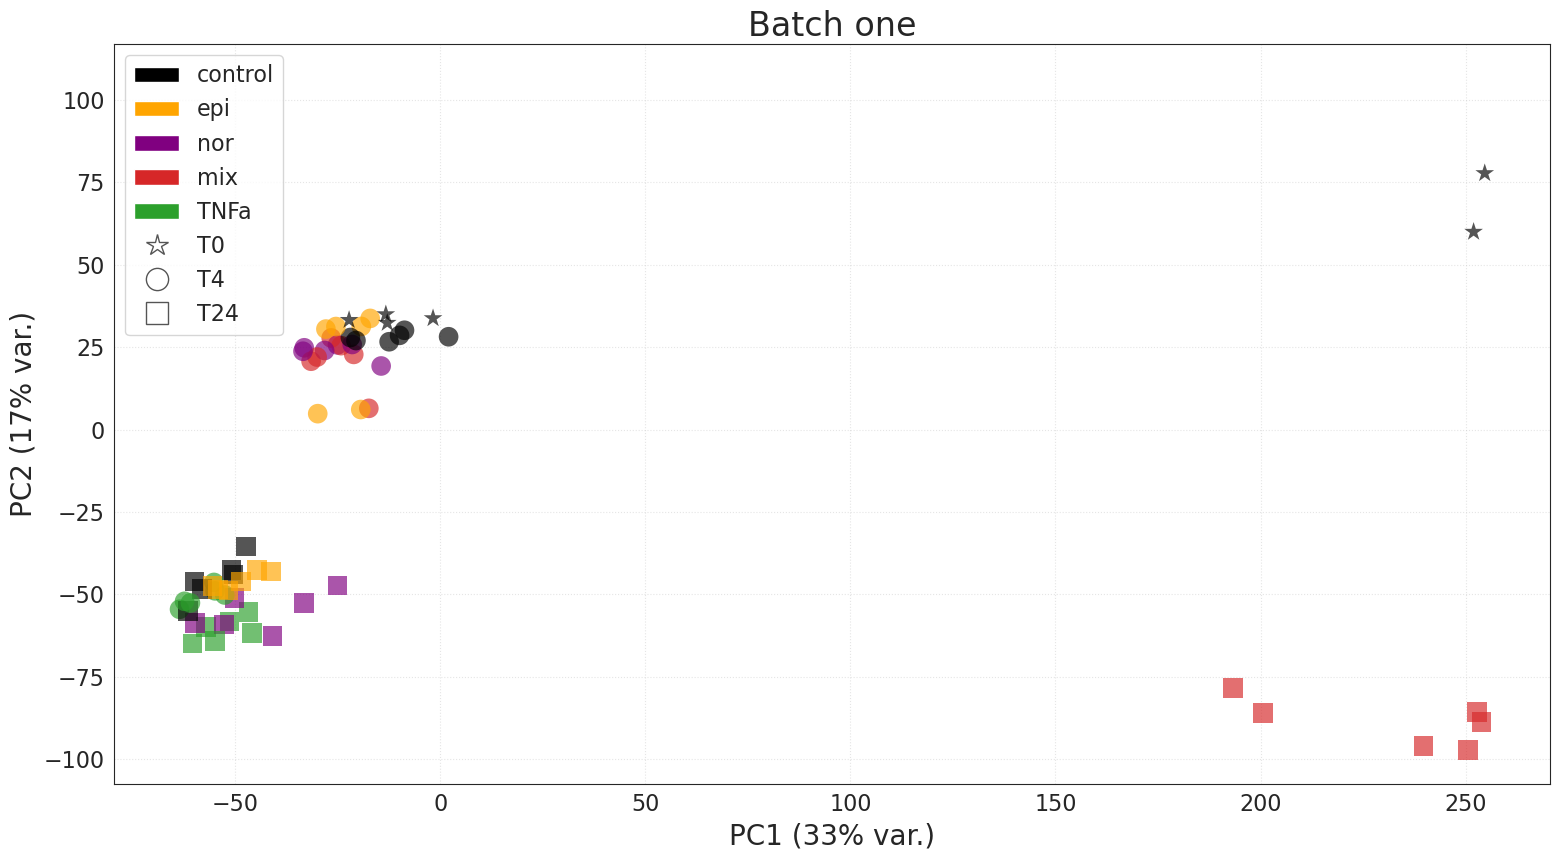

In [58]:
sampleIDs = mqndf.columns
subset_metadata = metadata.loc[sampleIDs, :]
batch_one_samples = subset_metadata[(subset_metadata['MS BATCH.1'] == 'B2_1') | (subset_metadata['MS BATCH.1'] == 'B2_2')].index
df = mqndf.loc[:, batch_one_samples]
df = df.transpose()

x = sklearn.preprocessing.StandardScaler().fit_transform(df)
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print('variance explained', pca.explained_variance_ratio_)

print(principal_df.shape)
principal_df.head()

for i in range(len(df.index)):
    
    label = df.index[i]
    
    # color for treatment
    treatment = metadata.loc[label, 'Treatment']
    if treatment == '0 µM' or treatment == '0µM' or type(treatment) == float:
        plotting_color = 'black'
    elif treatment == '5 µM epi':
        plotting_color = 'orange'
    elif treatment == '5 µM nor':
        plotting_color = 'purple'
    elif treatment == '5 µM epi:nor':
        plotting_color = 'tab:red'
    elif treatment == 'TNFa':
        plotting_color = 'tab:green'
    else:
        plotting_color = 'blue'
        print(treatment, type(treatment))
    
    # marker for pools or real sample
    long_sample_name = metadata.loc[label, 'LCMS_SAMPLE']
    timepoint = metadata.loc[label, 'Timepoint']
    if timepoint == 0:
        plotting_marker = '*'
    elif timepoint == 4:
        plotting_marker = 'o'
    elif timepoint == 24:
        plotting_marker = 's'
    else:
        print(timepoint)
    if '072' not in long_sample_name:
        plotting_marker = 'none'

    # position
    posx = principal_df.iloc[i]['PC1']
    posy = principal_df.iloc[i]['PC2']

    # plot the dots
    matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, marker=plotting_marker, edgecolors='none')
    
# legend
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='orange', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='purple', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white'),
    
    matplotlib.lines.Line2D([0], [0], marker='*', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='s', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0)
    ]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'mix', 'TNFa', 'T0', 'T4', 'T24'], fontsize=16)


# close figure
matplotlib.pyplot.title('Batch one')
matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1 ({}% var.)'.format(int(pca.explained_variance_ratio_[0]*100)))
matplotlib.pyplot.ylabel('PC2 ({}% var.)'.format(int(pca.explained_variance_ratio_[1]*100)))

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
this one looks more appropriate. remove extreme samples and replot.

# determine response patterns

In [ ]:
# what changes between 0 and 4 hours in zero vs mix

In [ ]:
treatments = list(metadata.loc[:, 'Treatment'].unique())
treatments = [element for element in treatments if element is not numpy.nan]
treatments.sort()
print(treatments)

timepoints = list(metadata.loc[:, 'Timepoint'].unique())
timepoints = [element for element in timepoints if numpy.isnan(element) == False]
timepoints.sort()
print(timepoints)

experiments = list(metadata.loc[:, 'Experiment'].unique())
experiments = [element for element in experiments if numpy.isnan(element) == False]
experiments.sort()
print(experiments)

bioreps = list(metadata.loc[:, 'Rep'].unique())
bioreps = [element for element in bioreps if numpy.isnan(element) == False]
bioreps.sort()
print(bioreps)

batches = list(metadata.loc[:, 'MS BATCH'].unique())
batches = [element for element in batches if numpy.isnan(element) == False]
batches.sort()
print(batches)

In [ ]:
%%time

for batch in batches:
    print('working with batch {}'.format(batch))
    
    rules = ((metadata.loc[:, 'Treatment'] == '0 µM') | (metadata.loc[:, 'Treatment'] == '0µM')) & (metadata.loc[:, 'Timepoint'] == 4) & (metadata.loc[:, 'MS BATCH'] == batch)
    control_samples = metadata[rules].index
    control_data = mqndf.loc[:, control_samples]
    print('\t', control_samples.shape, control_data.shape, control_samples[:3])
    
    rules = (metadata.loc[:, 'Treatment'] == '5 µM epi:nor') & (metadata.loc[:, 'Timepoint'] == 4) & (metadata.loc[:, 'MS BATCH'] == batch)
    treatment_samples = metadata[rules].index
    treatment_data = mqndf.loc[:, treatment_samples]
    print('\t', treatment_samples.shape, treatment_data.shape, treatment_samples[:3])
    
    log2FC = treatment_data.median(axis=1) - control_data.median(axis=1)
    print('\t', log2FC.shape, numpy.min(log2FC), numpy.max(log2FC))
    
    [statistics, Pvalues] = scipy.stats.ttest_ind(treatment_data, control_data, axis=1)
    #print('\t', Pvalues.shape)
    
    results = statsmodels.stats.multitest.multipletests(Pvalues, alpha=0.05, method='fdr_bh')
    # fdr_bh ==> 575
    # fdr_by ==> 99
    # fdr_tsbh ==> 586
    # fdr_tsbky ==> 572    
    rejected = results[0]; corrected_P = results[1]
    print(numpy.max(-numpy.log10(corrected_P)))
    
    #
    # plot
    #
    bluex = []; bluey = []
    redx = []; redy = []
    blackx = []; blacky = []
    
    for i in range(len(rejected)):
        if rejected[i] == True:

            x = log2FC[i]
            y = -numpy.log10(corrected_P[i])
            if x <= -1:
                bluex.append(x); bluey.append(y)
            elif x >= 1:
                redx.append(x); redy.append(y)
            else:
                blackx.append(x); blacky.append(y)
    
    # plot figure
    selected = numpy.random.randint(0, high=len(blackx), size=int(len(blackx)/10))
    matplotlib.pyplot.scatter([blackx[i] for i in selected], [blacky[i] for i in selected], s=50, c='black', alpha=1/10, edgecolors='none')
    matplotlib.pyplot.scatter(bluex, bluey, s=100, c='tab:blue', alpha=1/3, edgecolors='none')
    matplotlib.pyplot.scatter(redx, redy, s=100, c='tab:red', alpha=1/3, edgecolors='none')
    
    # close figure
    matplotlib.pyplot.xlim(-4, 4)
    matplotlib.pyplot.ylim(0, 10)

    matplotlib.pyplot.xlabel('Change [log2 FC]')
    matplotlib.pyplot.ylabel('Significance [-log10 adj P]')
    matplotlib.pyplot.grid(ls=':', alpha=0.5)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    print()
    

In [ ]:
### plot the most top most and least different